 **IMPORTING USEFUL PACKAGES**

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

**Showing Results**

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


 **Generator Model**

In [3]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        # nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

**Noise Vector**

In [5]:
def get_noise(n_samples, z_dim, device='cuda'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    return torch.randn(n_samples,z_dim,device=device)

**Discriminator**

In [6]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )

In [7]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

**Training**

In [8]:
# Set parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Discriminator loss:

In [10]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
   
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

Generator Loss:

In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
   
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.1105074421167378, discriminator loss: 0.5065160012841229


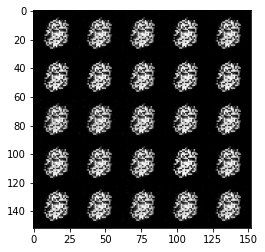

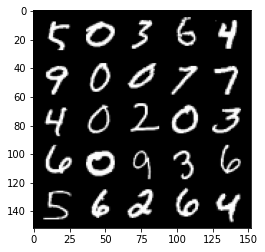

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.0407139468193067, discriminator loss: 0.5724620752334593


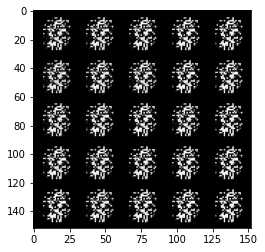

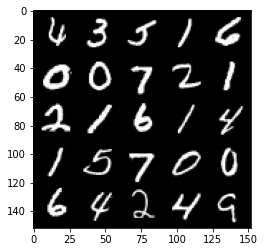

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.0688626104593275, discriminator loss: 0.4970004133582114


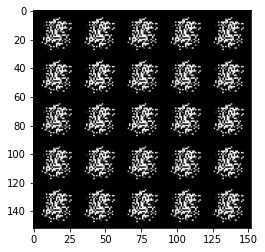

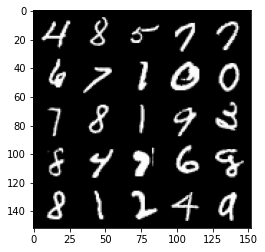

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.218831992030142, discriminator loss: 0.47995449888706226


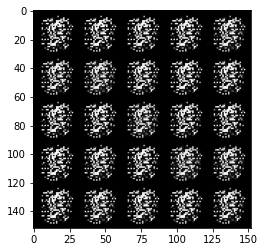

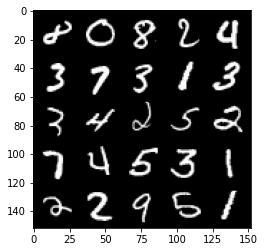

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.4055019891262064, discriminator loss: 0.4041429417133326


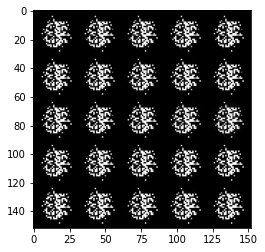

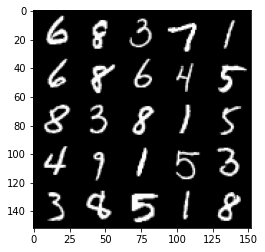

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.380295841217041, discriminator loss: 0.46751030117273357


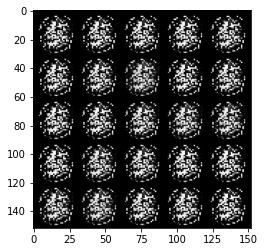

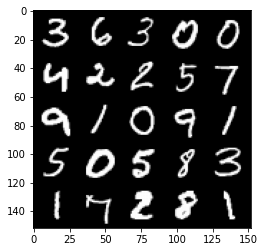

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 1.649855061054229, discriminator loss: 0.29431377106904977


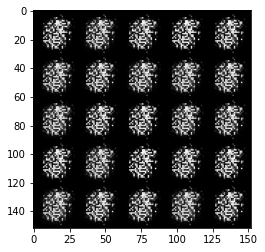

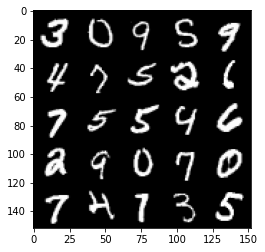

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 1.5468751120567301, discriminator loss: 0.32318215054273597


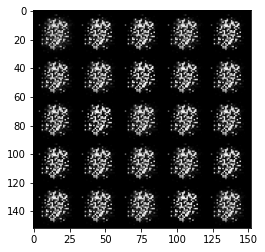

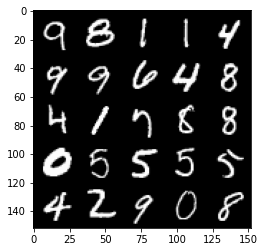

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 1.4912175004482269, discriminator loss: 0.3008181948959829


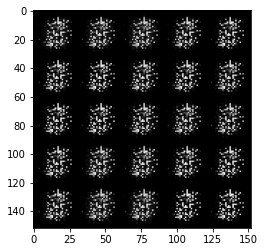

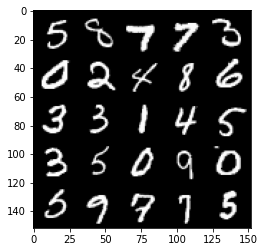

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 1.4107080852985383, discriminator loss: 0.3292226447165012


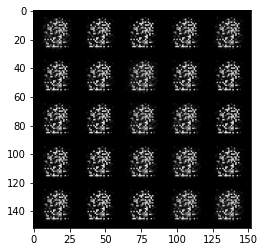

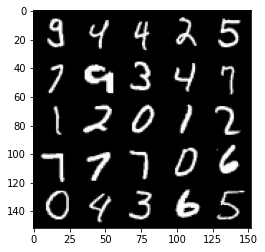

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 1.552478347539901, discriminator loss: 0.2718965433537961


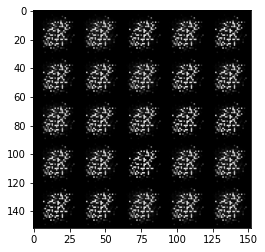

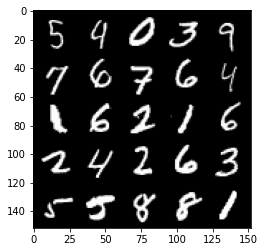

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 1.8207866687774652, discriminator loss: 0.22551604342460638


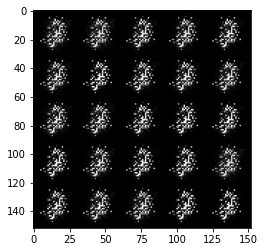

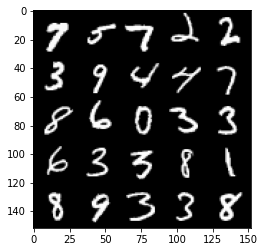

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 2.206789747953413, discriminator loss: 0.17102387051284307


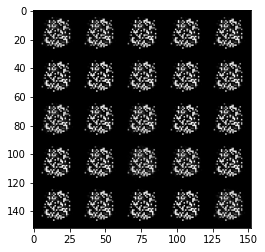

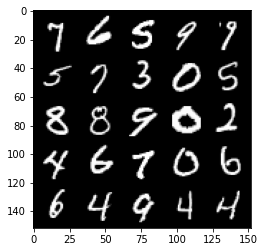

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 2.84585118293762, discriminator loss: 0.08054051141440868


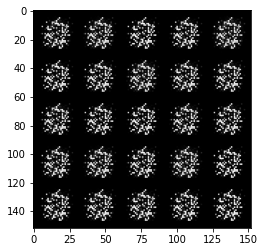

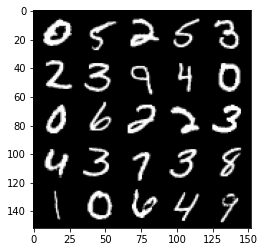

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 3.165900259971619, discriminator loss: 0.07171335786581044


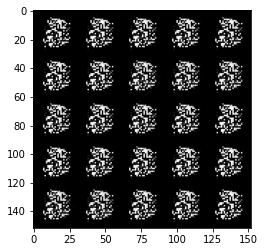

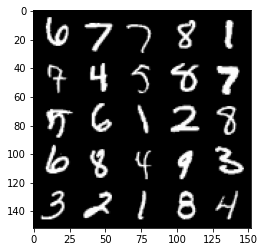

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 3.525340420722961, discriminator loss: 0.04962526090815667


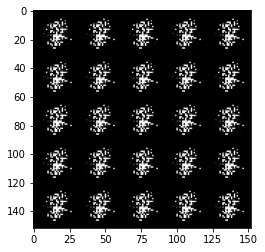

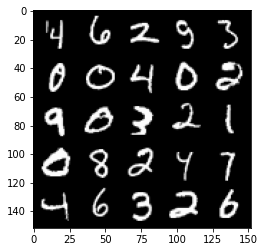

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 3.4562029752731305, discriminator loss: 0.057853608276695


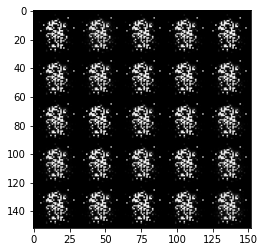

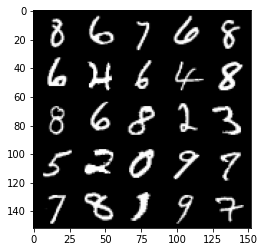

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 3.748066397190093, discriminator loss: 0.04659987376630313


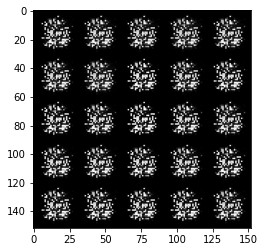

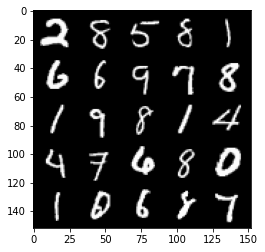

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 4.2314005756378155, discriminator loss: 0.02929837307333946


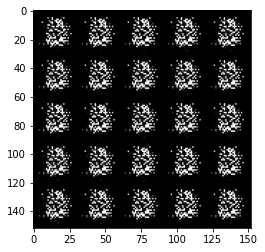

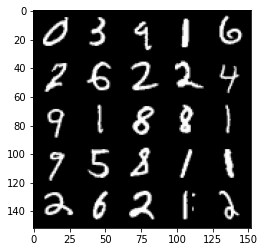

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.232770165443421, discriminator loss: 0.029344021443277562


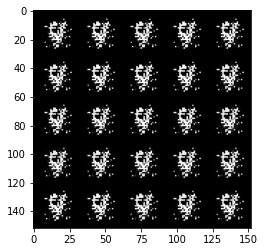

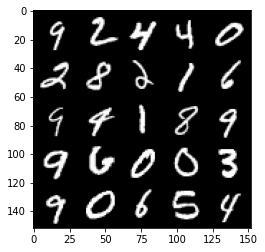

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 4.328318105697636, discriminator loss: 0.026813763728365327


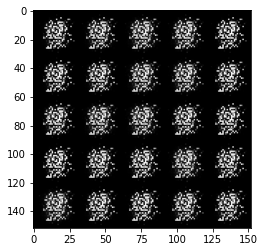

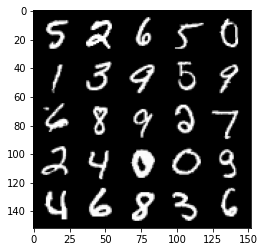

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 4.6586079401969895, discriminator loss: 0.02099433431588111


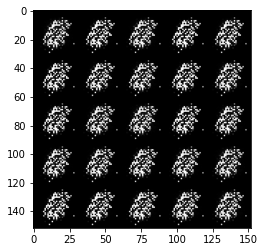

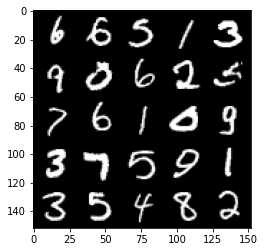

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 4.859261560440063, discriminator loss: 0.01582427669875325


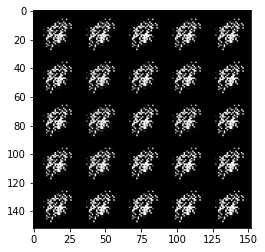

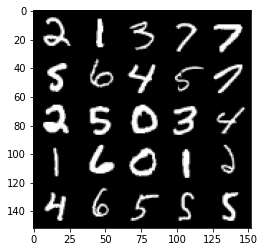

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 4.888813938140868, discriminator loss: 0.01389173833094538


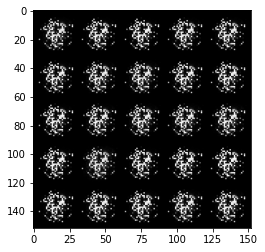

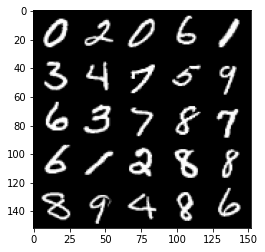

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 5.108666976928713, discriminator loss: 0.013045225584879517


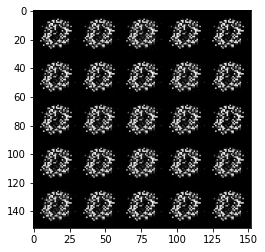

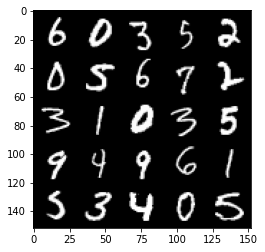

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 5.345998589515688, discriminator loss: 0.012710758729372171


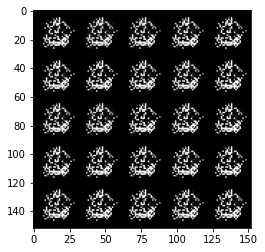

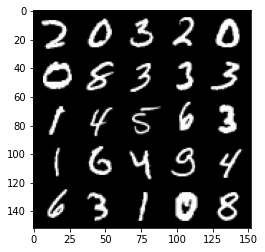

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 5.497553043365474, discriminator loss: 0.008747731880284852


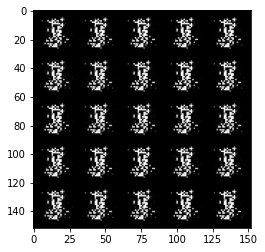

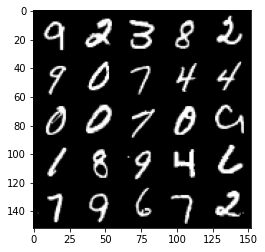

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 5.078517424583434, discriminator loss: 0.015541676228400322


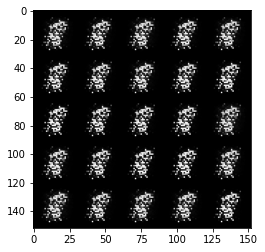

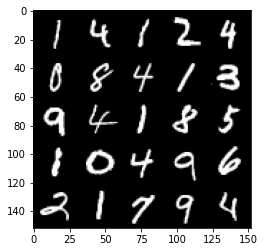

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 5.0564529228210455, discriminator loss: 0.016543705641292036


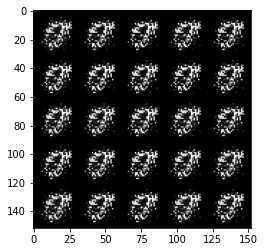

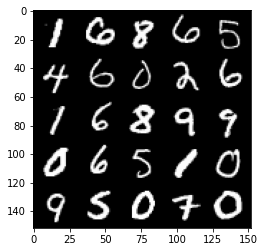

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 5.594139824867243, discriminator loss: 0.009807313587050882


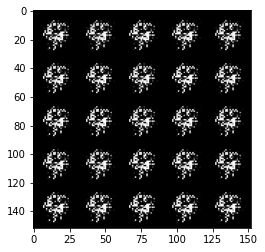

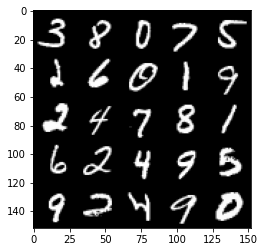

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 5.764663431167603, discriminator loss: 0.0073603368862532135


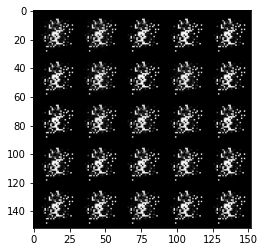

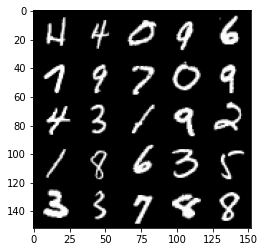

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 5.7390281991958645, discriminator loss: 0.008359854803420597


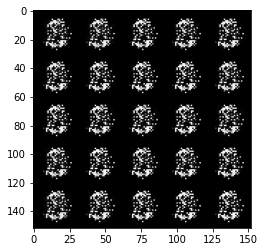

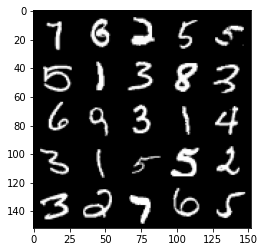

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 5.811739734649661, discriminator loss: 0.009298068649135531


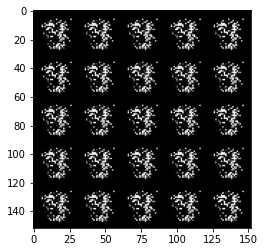

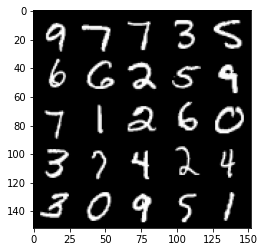

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 5.705304877281188, discriminator loss: 0.01000395230110735


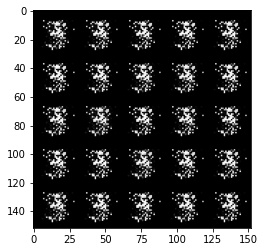

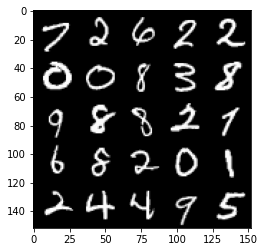

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 5.8127482328414946, discriminator loss: 0.00671835353900678


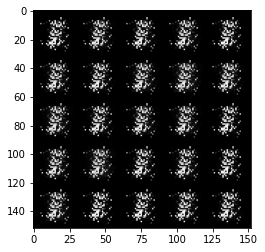

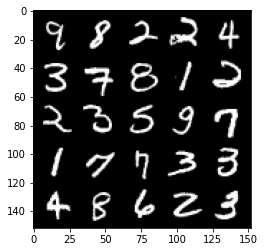

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 5.940426238059992, discriminator loss: 0.007131238958332685


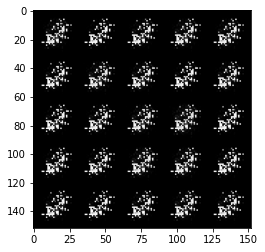

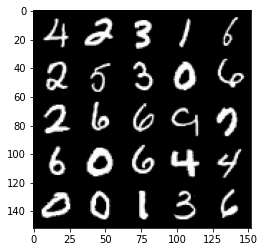

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 6.115321108818056, discriminator loss: 0.005843397855758668


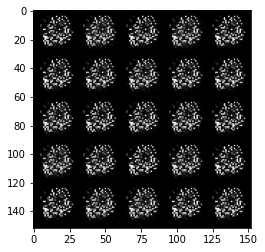

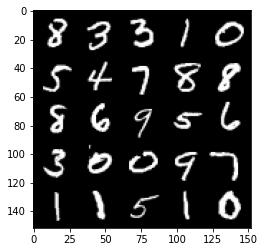

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 6.301112092018126, discriminator loss: 0.006581689011072744


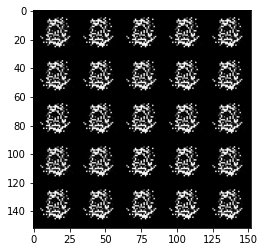

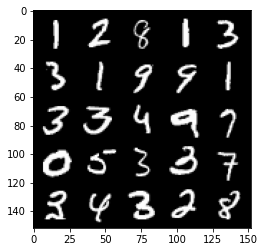

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 6.409031421661371, discriminator loss: 0.00559749440458836


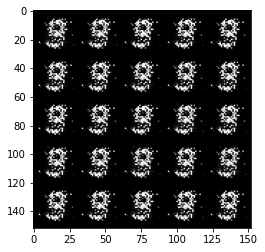

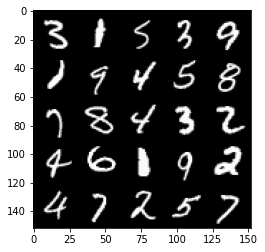

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 6.244624057769781, discriminator loss: 0.005275141334917863


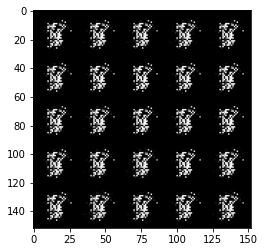

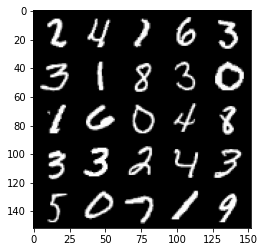

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 6.0464829874038735, discriminator loss: 0.007441685979021718


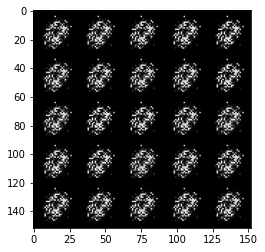

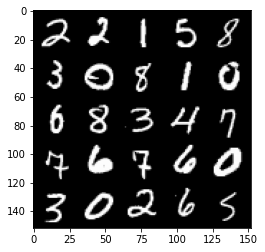

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 6.20385861015319, discriminator loss: 0.009728914495790384


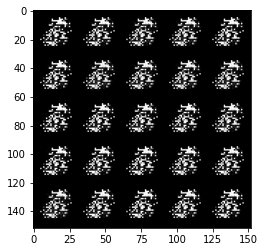

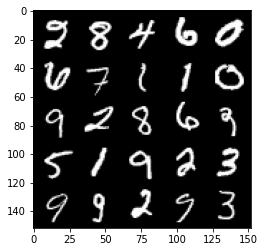

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 6.356776599884034, discriminator loss: 0.006744161157112098


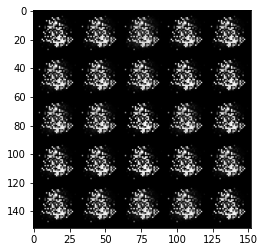

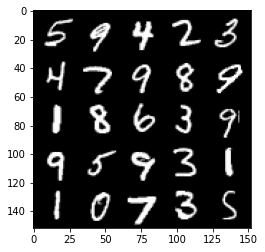

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 6.50217875099182, discriminator loss: 0.006049572647549208


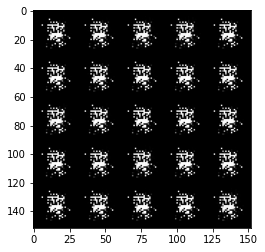

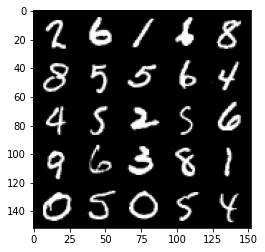

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 6.563274880409244, discriminator loss: 0.005177607972174884


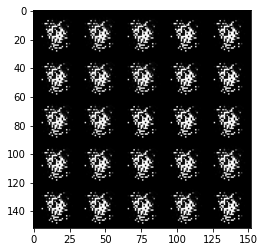

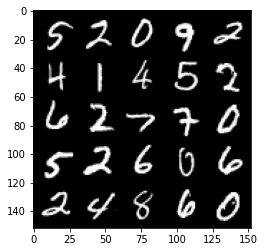

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 6.701732092857359, discriminator loss: 0.004762225782091263


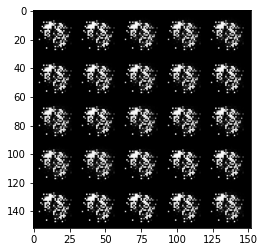

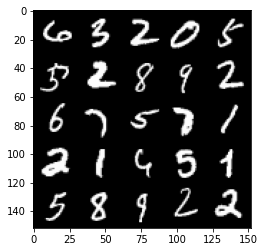

In [12]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False
gen_losses = []
disc_losses = []
counter=0
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        

        # Keep track of the average discriminator loss
        disc_losses.append(disc_loss.item())
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        gen_losses.append(gen_loss.item())
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
        counter += 1

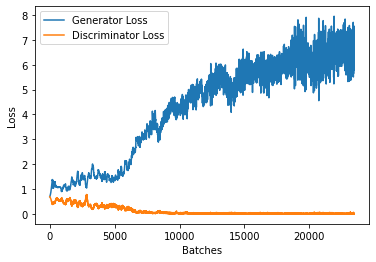

In [13]:
fig, axis = plt.subplots()
axis.plot(np.arange(counter),gen_losses,label="Generator Loss")
axis.plot(np.arange(counter),disc_losses,label="Discriminator Loss")
plt.ylabel('Loss')
plt.xlabel('Batches')
axis.legend()
plt.show()